# Network analysis
First, import relevant libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pylab import *

import igraph as ig # Need to install this in your virtual environment

import psycopg2
from re import sub

In [2]:
import os
import sys
sys.path.append('/home/mmalik/optourism-repo' + "/pipeline")
from firenzecard_analyzer import *

In [3]:
# TODO: connect with dbutils
conn_str = ""
conn = psycopg2.connect(conn_str)
cursor = conn.cursor()

In [41]:
# df = get_firenze_data(conn)

In [42]:
# df.head()

In [43]:
# ft = extract_features(df)
# ft.head()

In [44]:
# ft[ft['user_id']==2036595][['user_id','entry_time','total_card_use_count','day_of_week','museum_name']]

In [45]:
# ft.columns

In [46]:
# test = ft.groupby('date')['total_users_per_card'].sum()

In [47]:
# test.head()

In [4]:
# temp = df.groupby(['user_id','museum_name','entry_time']).sum()
# temp[temp['is_card_with_minors']>0].head(50)

In [5]:
# temp[(temp['is_card_with_minors']>0)&(temp['entry_is_adult']==0)]

Then, load the data (takes a few moments):

In [4]:
nodes = pd.read_sql('select * from optourism.firenze_card_locations', con=conn)
nodes.head()

,name,longitude,latitude,id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,0
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,1
2,Battistero di San Giovanni,11.254966,43.773131,3,San Giovanni,2
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,3
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,4


In [5]:
df = pd.read_sql('select * from optourism.firenze_card_logs', con=conn)
df['museum_id'].replace(to_replace=38,value=39,inplace=True)
df['short_name'] = df['museum_id'].replace(dict(zip(nodes['id'],nodes['short_name'])))
df['string'] = df['museum_id'].replace(dict(zip(nodes['id'],nodes['string'])))
df['date'] = pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df['hour'] = pd.to_datetime(df['date']) + pd.to_timedelta(pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.hour, unit='h')
df.head()

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,museum_id,short_name,string,date,hour
0,2070971,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,39,Palazzo Pitti,a,2016-08-08,2016-08-08 11:00:00
1,2070972,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,39,Palazzo Pitti,a,2016-08-08,2016-08-08 11:00:00
2,2071063,Palazzo Pitti Cumulativo,2016-08-08 11:40:00,0,1,1,0,39,Palazzo Pitti,a,2016-08-08,2016-08-08 11:00:00
3,2070258,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,39,Palazzo Pitti,a,2016-08-08,2016-08-08 11:00:00
4,2069915,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,39,Palazzo Pitti,a,2016-08-08,2016-08-08 11:00:00


In [6]:
# Helper function for making summary tables/distributions
def frequency(dataframe,columnname):
    out = dataframe[columnname].value_counts().to_frame()
    out.columns = ['frequency']
    out.index.name = columnname
    out.reset_index(inplace=True)
    out.sort_values(columnname,inplace=True)
    out['cumulative'] = out['frequency'].cumsum()/out['frequency'].sum()
    out['ccdf'] = 1 - out['cumulative']
    return out

I propose distinguishing _paths_ from _flows_. A path is an itinerary, and the flow is the number of people who take the flow. E.g., a family or a tour group produces one path, but adds mulitple people to the overall flow. 

We now build a transition graph, a directed graph where an edge represents a person going from one museum to another *within the same day*. 

We also produce the *transition matrix,* a row-normalized n-by-n matrix of the frequency of transition from the row node to the column node. If you take a vector of the current volumes in each location, and multiply that my the transition matrix, you get a prediction for the number of people on each node at the next time. This prediction can be refined with corrections for daily/weekly patterns and such. 

# Other exploratory/summary plots

In [7]:
timeunitname = 'hour'
timeunitcode = 'h'
df1 = df.groupby(['short_name',timeunitname]).sum()
df1['total_people'] = df1['total_adults']+df1['minors']
df1.drop(['museum_id','user_id','adults_first_use','adults_reuse','total_adults','minors'], axis=1, inplace=True)
df1.head()

total_people
short_name hour                             
Accademia  2016-06-01 08:00:00            17
           2016-06-01 09:00:00            37
           2016-06-01 10:00:00            51
           2016-06-01 11:00:00            33
           2016-06-01 12:00:00            36

In [8]:
df1 = df1.reindex(pd.MultiIndex.from_product([df['short_name'].unique(),pd.date_range('2016-06-01','2016-10-01',freq=timeunitcode)]), fill_value=0)
df1.reset_index(inplace=True)
df1.columns = ['short_name','hour','total_people']
df1.head()

,short_name,hour,total_people
0,Palazzo Pitti,2016-06-01 00:00:00,0
1,Palazzo Pitti,2016-06-01 01:00:00,0
2,Palazzo Pitti,2016-06-01 02:00:00,0
3,Palazzo Pitti,2016-06-01 03:00:00,0
4,Palazzo Pitti,2016-06-01 04:00:00,0


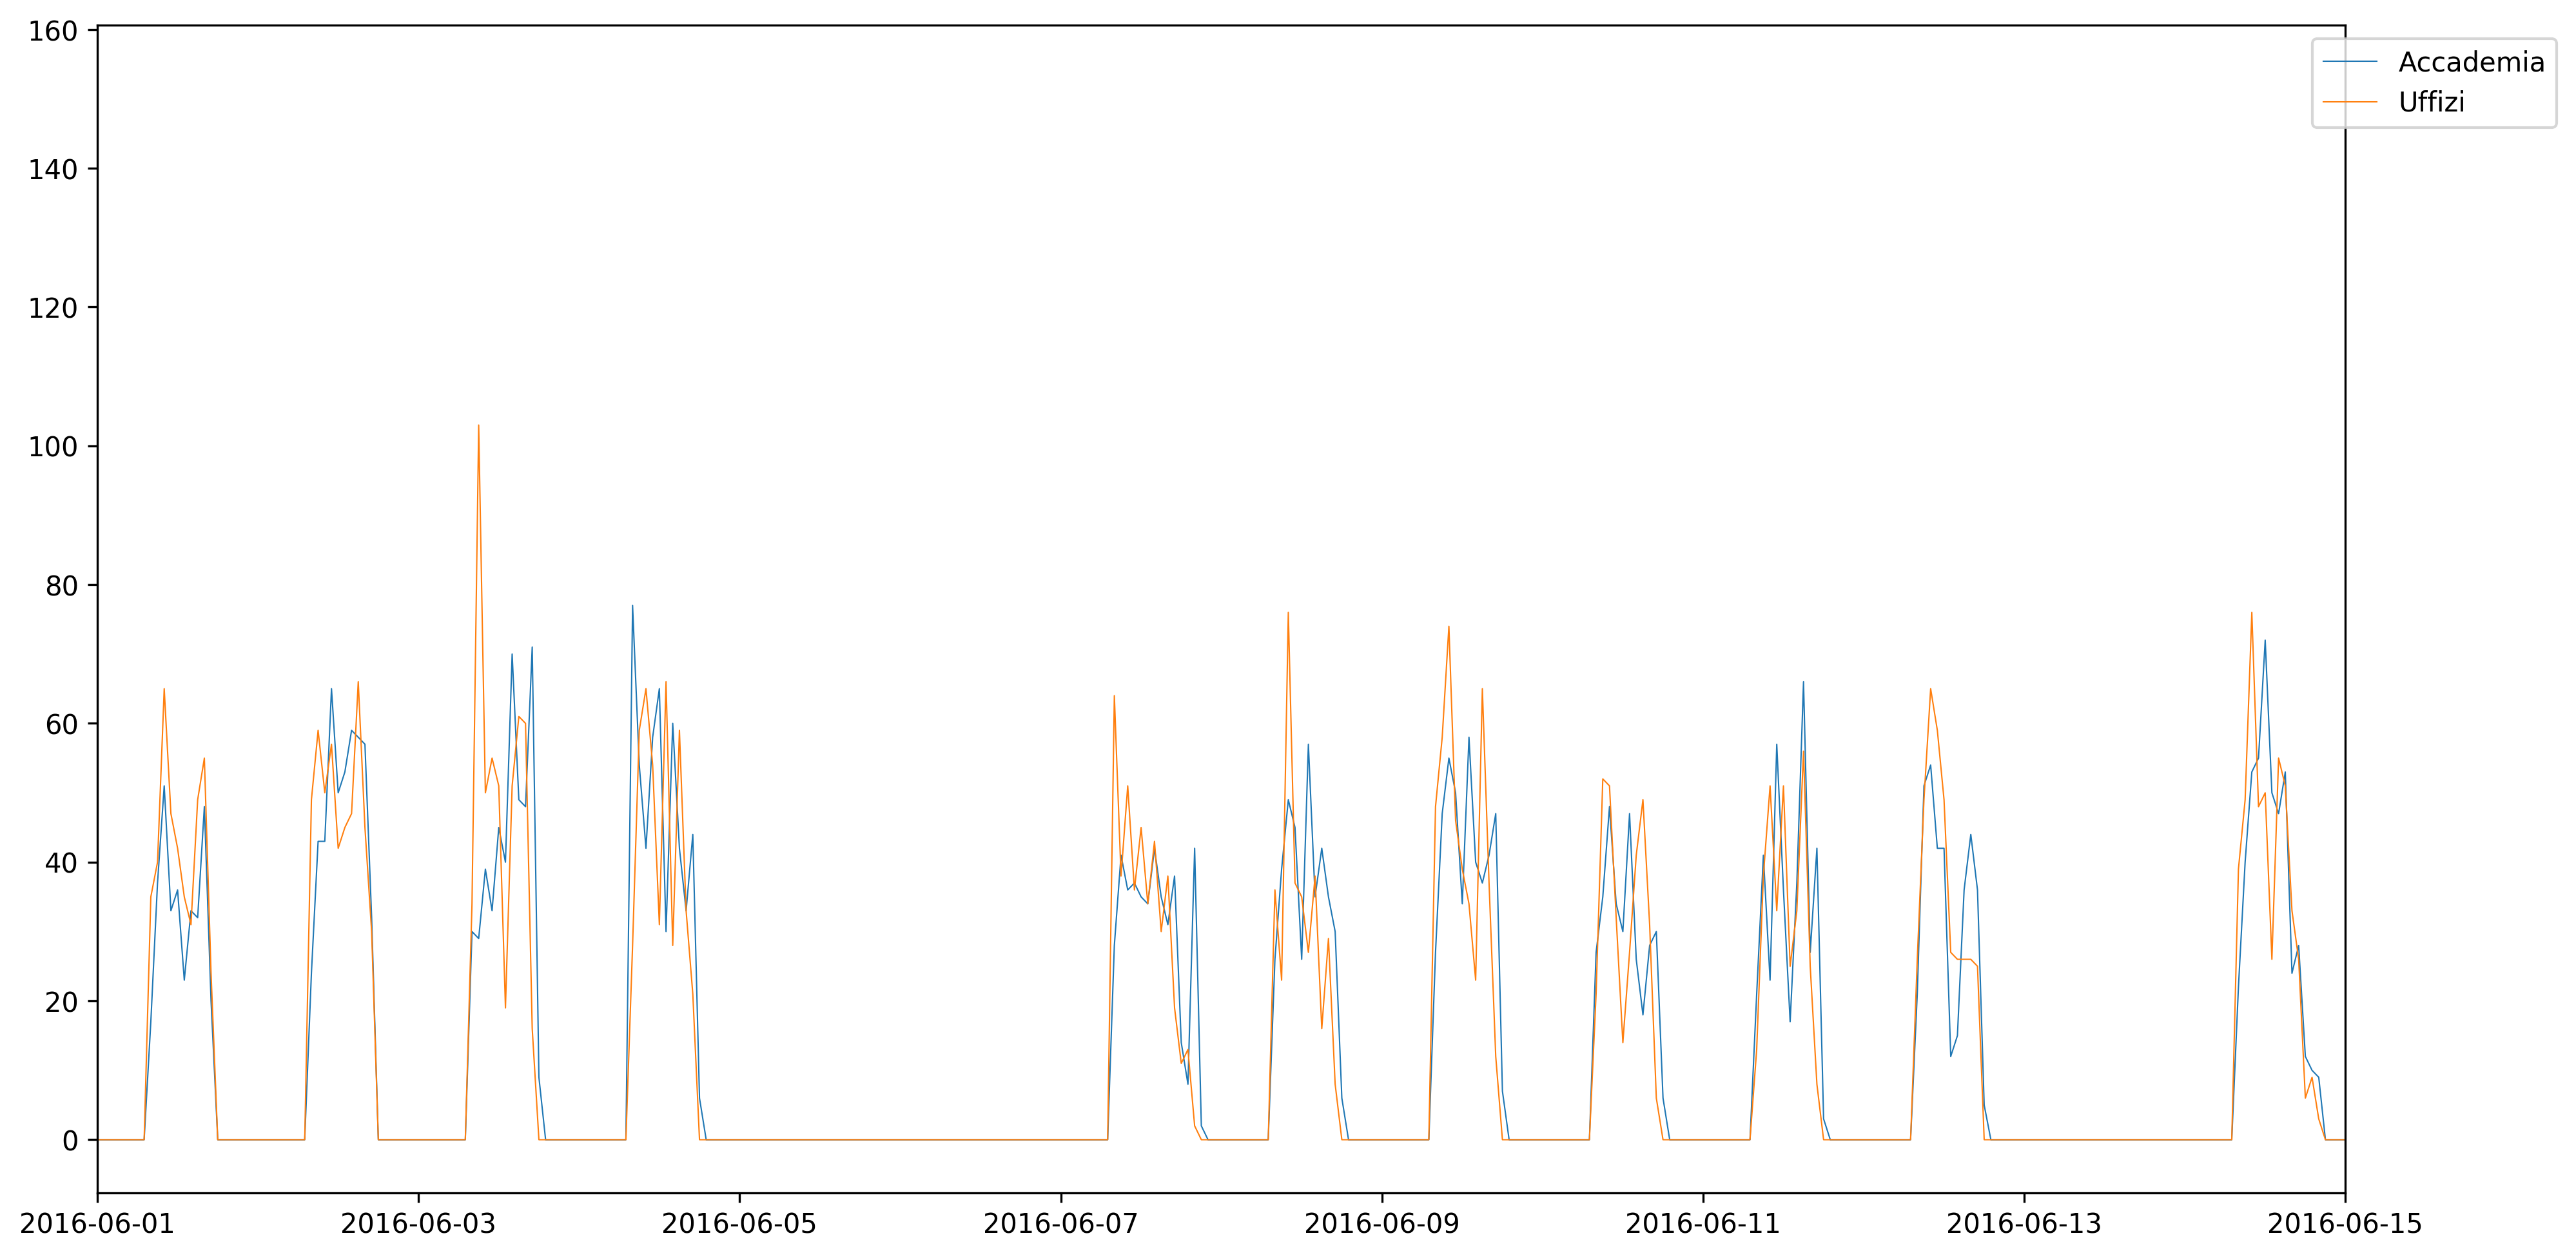

In [9]:
# multiline plot with group by
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,8), dpi=300)
for key, grp in df1.groupby(['short_name']):
    if key in ['Accademia','Uffizi']:
        ax.plot(grp['hour'], grp['total_people'], linewidth=.5, label=str(key))
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
ax.set_xlim(['2016-06-01','2016-06-15'])
plt.show()

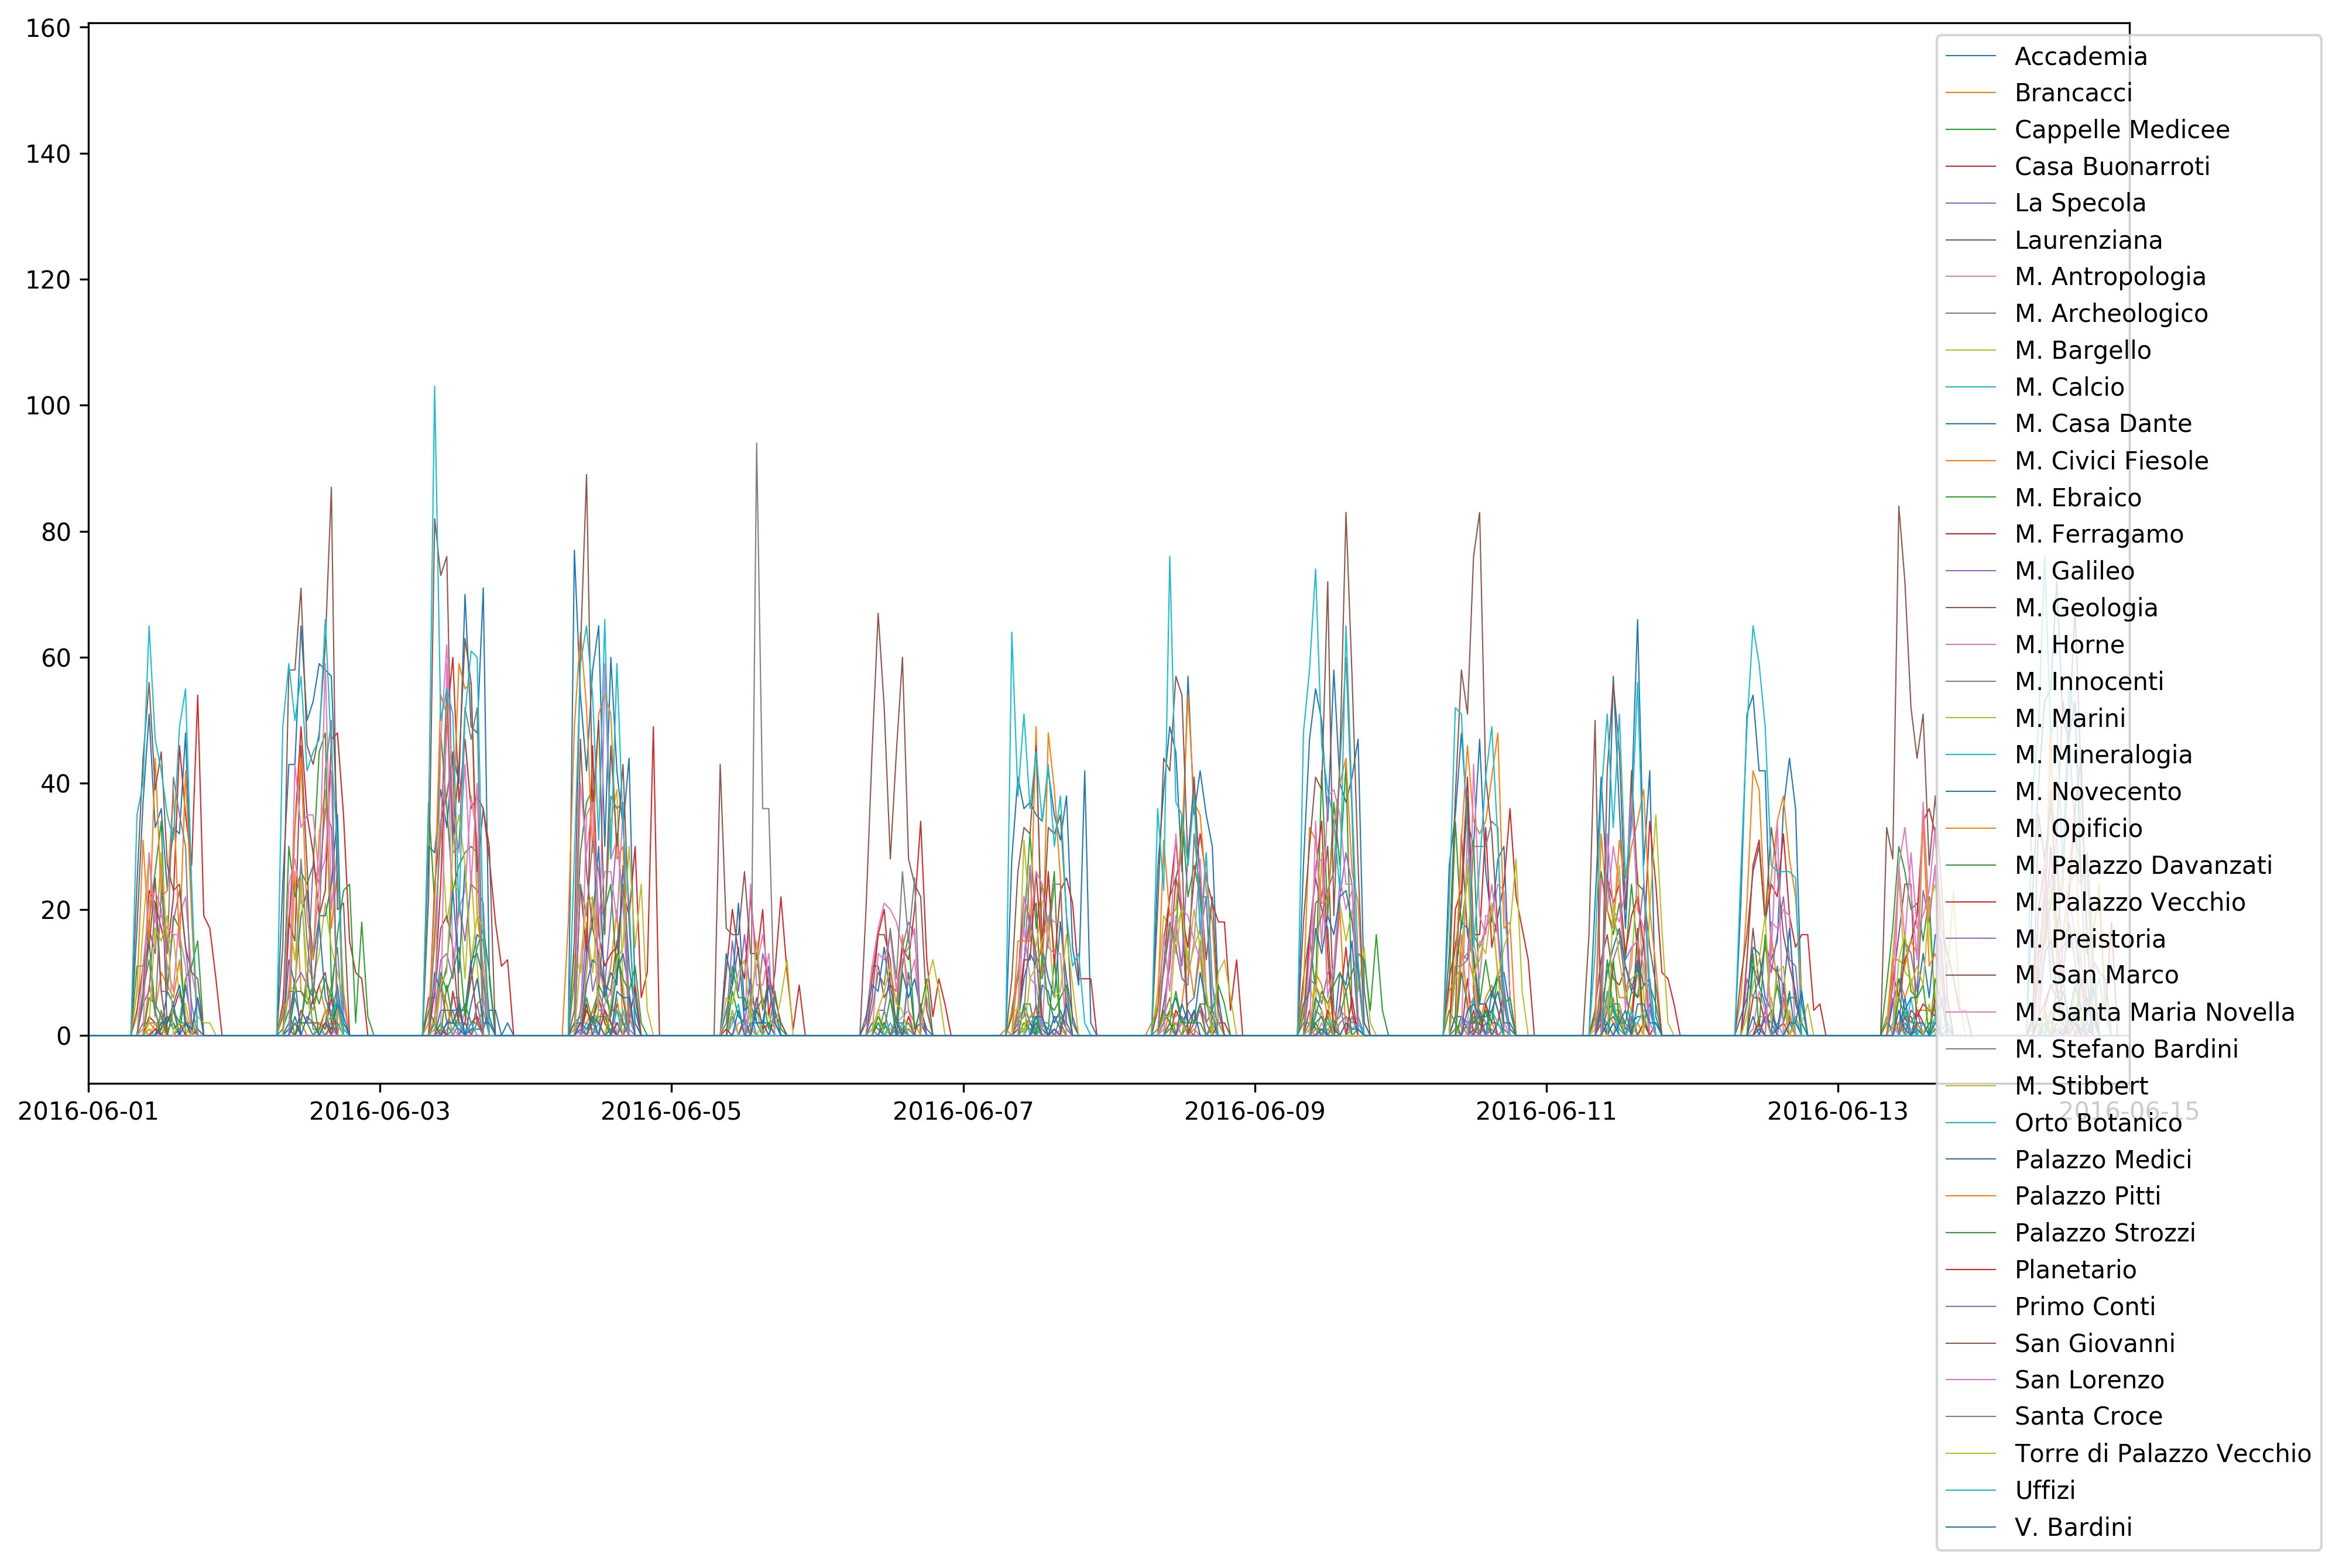

In [10]:
# multiline plot with group by
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,8), dpi=300)
for key, grp in df1.groupby(['short_name']):
    ax.plot(grp['hour'], grp['total_people'], linewidth=.5, label=str(key))
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
ax.set_xlim(['2016-06-01','2016-06-15'])
plt.show()

In [11]:
df2 = df.groupby('museum_name').sum()[['total_adults','minors']]
df2['total_people'] = df2['total_adults'] + df2['minors']
df2.sort_values('total_people',inplace=True,ascending=False)
df2.head()

,total_adults,minors,total_people
museum_name,,,
Battistero di San Giovanni,44047,5842,49889
Galleria degli Uffizi,40622,3717,44339
Galleria dell'Accademia di Firenze,39364,3053,42417
Museo di Palazzo Vecchio,29403,3354,32757
"Palazzo Pitti 2 Ð Giardino di Boboli, Museo degli Argenti, Museo delle Porcellan",29142,3155,32297


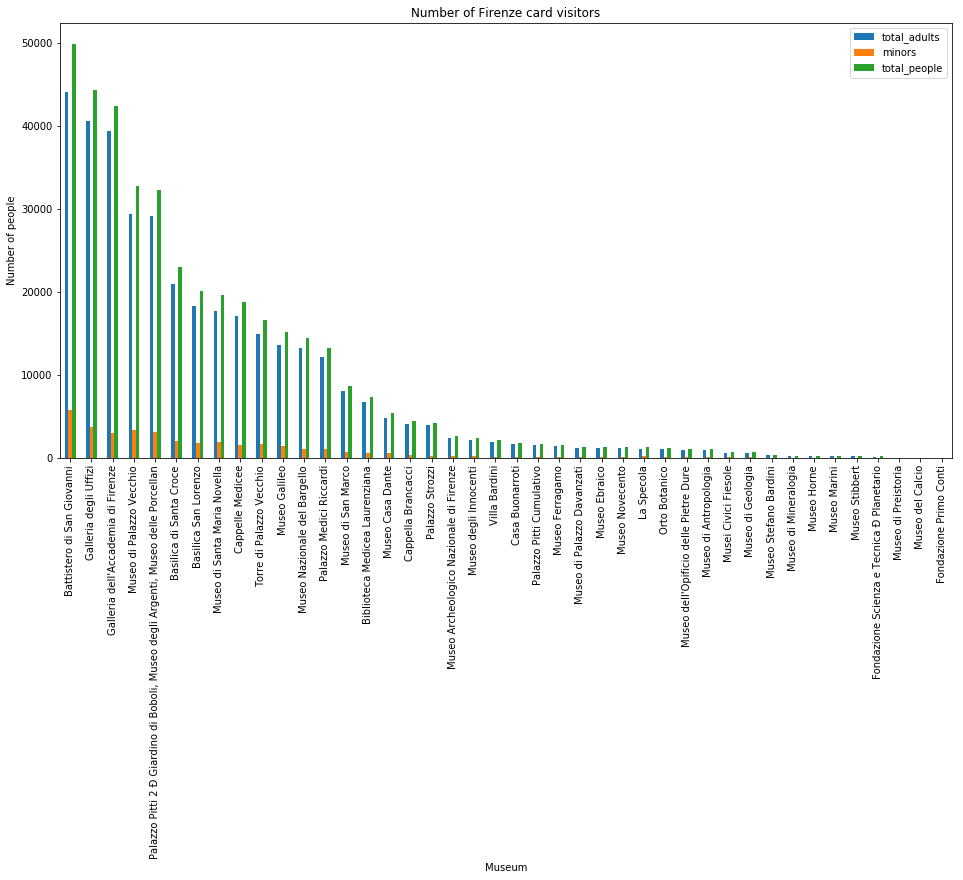

In [12]:
df2.plot.bar(figsize=(16,8))
plt.title('Number of Firenze card visitors')
plt.xlabel('Museum')
plt.ylabel('Number of people')
# plt.yscale('log')
plt.show()

# Transition/Origin-Destination (OD) matrix 

Now, we make a graph of the transitions for museums. To do this, we make an edgelist out of the above. 

Specifically, we want an edgelist where the first column is the origin site, the second column is the destination site, the third column is the number of people (total adults plus rows for minors), and the fourth column is the time stamp of the entry to the _destination_ museum. 

But, there's a twist. We want to track when people arrive at the first museum of their day. We can do this by adding a dummy "source" node that everybody starts each day from. We can then query this dummy node to see not only which museum people activate their Firenze card from, but also the museum where they start their other days. For visualizations, we can drop it (or not visualize it). 

We could also have people return to this source node at the end of each day (or make a separate "target" node for this purpose), but there would be no timestamp for that arrival so it would complicate the data with missing values. However, we might still want to do this, analogously to find the last museum people tend to visit in a day. 

I will create this source node by the following: first, create an indicator for if the previous record is the same day and the same Firenze card. If it is, we make a link from the museum of the previous row and the museum of that row. 

If the previous row is either a different day and/or a different user_id, make a link between the dummy "source" node and that row's museum. 

I do this below in a different order: I initialize a "from" column with all source, then overwrite with the museum of the previous row if the conditions are met. 

In [13]:
# df3 = df.sort_values(['user_id','entry_time'],ascending=False,inplace=False)
# df3.reset_index(inplace=True)
# df3.drop(['index','museum_id'], axis=1, inplace=True)
# df3.head()
# df3.groupby(['user_id','date','museum_name','entry_time']).sum().head(10) # Even though this grouping's multiindex looks nicer

In [14]:
df4 = df.groupby(['user_id','entry_time','date','hour','museum_name','short_name','string']).sum() # Need to group in this order to be correct further down
df4['total_people'] = df4['total_adults'] + df4['minors']
df4.head()

adults_first_use  \
user_id entry_time          date       hour                museum_name                        short_name    string                     
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi        9                      1   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante C                      0   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia     _                      0   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         San Giovanni  2                      0   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo    Q                      0   

                                                                                                                    adults_reuse  \
user_id entry_time          date       hour                museum_name                        short_name    string                 
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi        9                  0   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante C                  1   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia     _                  1   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         San Giovanni  2                  1   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo    Q                  1   

                                                                                                                    total_adults  \
user_id entry_time          date       hour                museum_name                        short_name    string                 
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi        9                  1   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante C                  1   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia     _                  1   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         San Giovanni  2                  1   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo    Q                  1   

                                                                                                                    minors  \
user_id entry_time          date       hour                museum_name                        short_name    string           
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi        9            0   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante C            0   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia     _            0   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         San Giovanni  2            0   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo    Q            0   

                                                                                                                    museum_id  \
user_id entry_time          date       hour                museum_name                        short_name    string              
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi        9              10   
        2016-06-22 14:26:00 2016-06-22 2016

In [15]:
df4.reset_index(inplace=True)
df4.drop(['adults_first_use','adults_reuse','total_adults','minors','museum_id'], axis = 1, inplace=True)
df4.head(10)

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,9,1
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,C,1
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,_,1
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,San Giovanni,2,1
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,Q,1
5,1459702,2016-06-23 12:57:00,2016-06-23,2016-06-23 12:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,K,1
6,1459702,2016-06-23 13:41:00,2016-06-23,2016-06-23 13:00:00,Museo Nazionale del Bargello,M. Bargello,T,1
7,1459702,2016-06-23 15:05:00,2016-06-23,2016-06-23 15:00:00,Basilica di Santa Croce,Santa Croce,0,1
8,1473903,2016-06-19 11:24:00,2016-06-19,2016-06-19 11:00:00,Galleria degli Uffizi,Uffizi,9,1
9,1473903,2016-06-20 12:05:00,2016-06-20,2016-06-20 12:00:00,Battistero di San Giovanni,San Giovanni,2,1


In [16]:
df4['from'] = 'source' # Initialize 'from' column with 'source'
df4['to'] = df4['short_name'] # Copy 'to' column with row's museum_name
df4.head(10)

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,9,1,source,Uffizi
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,C,1,source,M. Casa Dante
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,_,1,source,Accademia
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,San Giovanni,2,1,source,San Giovanni
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,Q,1,source,M. Galileo
5,1459702,2016-06-23 12:57:00,2016-06-23,2016-06-23 12:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,K,1,source,M. Palazzo Vecchio
6,1459702,2016-06-23 13:41:00,2016-06-23,2016-06-23 13:00:00,Museo Nazionale del Bargello,M. Bargello,T,1,source,M. Bargello
7,1459702,2016-06-23 15:05:00,2016-06-23,2016-06-23 15:00:00,Basilica di Santa Croce,Santa Croce,0,1,source,Santa Croce
8,1473903,2016-06-19 11:24:00,2016-06-19,2016-06-19 11:00:00,Galleria degli Uffizi,Uffizi,9,1,source,Uffizi
9,1473903,2016-06-20 12:05:00,2016-06-20,2016-06-20 12:00:00,Battistero di San Giovanni,San Giovanni,2,1,source,San Giovanni


In [17]:
make_link = (df4['user_id'].shift(1)==df4['user_id'])&(df4['date'].shift(1)==df4['date']) # Row indexes at which to overwrite 'source'
df4['from'][make_link] = df4['short_name'].shift(1)[make_link]
df4.head(50)

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,9,1,source,Uffizi
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,C,1,Uffizi,M. Casa Dante
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,_,1,M. Casa Dante,Accademia
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,San Giovanni,2,1,source,San Giovanni
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,Q,1,San Giovanni,M. Galileo
5,1459702,2016-06-23 12:57:00,2016-06-23,2016-06-23 12:00:00,Museo di Palazzo Vecchio,M. Palazzo Vecchio,K,1,M. Galileo,M. Palazzo Vecchio
6,1459702,2016-06-23 13:41:00,2016-06-23,2016-06-23 13:00:00,Museo Nazionale del Bargello,M. Bargello,T,1,M. Palazzo Vecchio,M. Bargello
7,1459702,2016-06-23 15:05:00,2016-06-23,2016-06-23 15:00:00,Basilica di Santa Croce,Santa Croce,0,1,M. Bargello,Santa Croce
8,1473903,2016-06-19 11:24:00,2016-06-19,2016-06-19 11:00:00,Galleria degli Uffizi,Uffizi,9,1,source,Uffizi
9,1473903,2016-06-20 12:05:00,2016-06-20,2016-06-20 12:00:00,Battistero di San Giovanni,San Giovanni,2,1,source,San Giovanni


In [18]:
df4['s'] = ' ' # Initialize 'from' column with 'source'
df4['t'] = df4['string'] # Copy 'to' column with row's museum_name
df4['s'][make_link] = df4['string'].shift(1)[make_link]
df4.head()

,user_id,entry_time,date,hour,museum_name,short_name,string,total_people,from,to,s,t
0,1459702,2016-06-22 10:04:00,2016-06-22,2016-06-22 10:00:00,Galleria degli Uffizi,Uffizi,9,1,source,Uffizi,,9
1,1459702,2016-06-22 14:26:00,2016-06-22,2016-06-22 14:00:00,Museo Casa Dante,M. Casa Dante,C,1,Uffizi,M. Casa Dante,9,C
2,1459702,2016-06-22 15:49:00,2016-06-22,2016-06-22 15:00:00,Galleria dell'Accademia di Firenze,Accademia,_,1,M. Casa Dante,Accademia,C,_
3,1459702,2016-06-23 09:43:00,2016-06-23,2016-06-23 09:00:00,Battistero di San Giovanni,San Giovanni,2,1,source,San Giovanni,,2
4,1459702,2016-06-23 11:14:00,2016-06-23,2016-06-23 11:00:00,Museo Galileo,M. Galileo,Q,1,San Giovanni,M. Galileo,2,Q


In [19]:
df5 = df4.groupby('user_id')['s'].sum().to_frame()
df5.head()

,s
user_id,
1459702,9C 2QKT
1473903,21 a
1473904,21 a
1473905,52_
1473906,ab9 _DM0 5


In [20]:
df6 = df5['s'].apply(lambda x: pd.Series(x.strip().split(' ')))
df6.head()

,0,1,2,3
user_id,,,,
1459702,9C,2QKT,NaN,NaN
1473903,21,a,NaN,NaN
1473904,21,a,NaN,NaN
1473905,52_,NaN,NaN,NaN
1473906,ab9,_DM0,5,NaN


In [21]:
df6.describe()

,0,1,2,3
count,51031,35338,17054,1548
unique,4891,4939,2941,294
top,2,9,a,_
freq,4433,2812,1062,112


In [22]:
df6.head(50)

,0,1,2,3
user_id,,,,
1459702,9C,2QKT,NaN,NaN
1473903,21,a,NaN,NaN
1473904,21,a,NaN,NaN
1473905,52_,NaN,NaN,NaN
1473906,ab9,_DM0,5,NaN
1473907,ab9,_DM0,5,NaN
1474634,1,,M_T,NaN
1474636,1,,M_T,NaN
2014298,a,NaN,NaN,NaN


In [23]:
# df4[df4['user_id']==2016016] # Do a check: before, my incorrect groupby order caused artifacts. 

In [24]:
# df4[(df4['from']=="Galleria dell'Accademia di Firenze")&(df4['to']=="Galleria degli Uffizi")] # Before, this result was empty

In [25]:
# # This manually checked the above result, to make sure I didn't make a mistake in creating the columns
# df4[((df4['museum_name'].shift(1)=="Galleria dell'Accademia di Firenze")\
#      &(df4['museum_name']=="Galleria degli Uffizi")\
#      &(df4['user_id']==df4['user_id'].shift(1))
#      &(df4['date']==df4['date'].shift(1))
#     )\
#    | \
#     ((df4['museum_name']=="Galleria dell'Accademia di Firenze")\
#      &(df4['museum_name'].shift(-1)=="Galleria degli Uffizi")\
#      &(df4['user_id']==df4['user_id'].shift(-1))
#      &(df4['date']==df4['date'].shift(-1))
#     )]

In [26]:
# df4[(df4['to']=="Galleria dell'Accademia di Firenze")&(df4['from']=="Galleria degli Uffizi")] # Once the above was finished, had to make sure the opposite problem didn't happen

In [27]:
# Create the actual edgelist for the transition matrix (of a first-order Markov chain)
df5 = df4.groupby(['from','to'])['total_people'].sum().to_frame()
df5.columns = ['weight']
df5.reset_index(inplace=True)
df5.head(10)

,from,to,weight
0,Accademia,Accademia,2
1,Accademia,Brancacci,77
2,Accademia,Cappelle Medicee,1277
3,Accademia,Casa Buonarroti,49
4,Accademia,La Specola,30
5,Accademia,Laurenziana,301
6,Accademia,M. Antropologia,51
7,Accademia,M. Archeologico,826
8,Accademia,M. Bargello,1022
9,Accademia,M. Calcio,2


In [28]:
# Create and check the graph
g2 = ig.Graph.TupleList(df5.itertuples(index=False), directed=True, weights=True)
ig.summary(g2)

IGRAPH DNW- 42 1240 -- 
+ attr: name (v), weight (e)


In [29]:
g2.vs['name']

['Accademia',
 'Brancacci',
 'Cappelle Medicee',
 'Casa Buonarroti',
 'La Specola',
 'Laurenziana',
 'M. Antropologia',
 'M. Archeologico ',
 'M. Bargello',
 'M. Calcio',
 'M. Casa Dante',
 'M. Civici Fiesole',
 'M. Ebraico',
 'M. Ferragamo',
 'M. Galileo',
 'M. Geologia',
 'M. Innocenti',
 'M. Marini',
 'M. Mineralogia',
 'M. Novecento',
 'M. Opificio',
 'M. Palazzo Davanzati',
 'M. Palazzo Vecchio',
 'M. San Marco',
 'M. Santa Maria Novella',
 'M. Stefano Bardini',
 'M. Stibbert',
 'Orto Botanico',
 'Palazzo Medici',
 'Palazzo Pitti',
 'Palazzo Strozzi',
 'Planetario',
 'San Giovanni',
 'San Lorenzo',
 'Santa Croce',
 'Torre di Palazzo Vecchio',
 'Uffizi',
 'V. Bardini',
 'M. Horne',
 'M. Preistoria',
 'Primo Conti',
 'source']

In [30]:
# Delete the dummy 'source' node
g2.delete_vertices([v.index for v in g2.vs if v['name']==u'source'])
ig.summary(g2)

IGRAPH DNW- 41 1199 -- 
+ attr: name (v), weight (e)


In [31]:
# Put in graph attributes to help with plotting
g2.vs['label'] = g2.vs["name"] # [sub("'","",i.decode('unicode_escape').encode('ascii','ignore')) for i in g2.vs["name"]] # Is getting messed up!
g2.vs['size'] = [.00075*i for i in g2.strength(mode='in',weights='weight')] # .00075 is from hand-tuning

In [32]:
g2.vs['label']

['Accademia',
 'Brancacci',
 'Cappelle Medicee',
 'Casa Buonarroti',
 'La Specola',
 'Laurenziana',
 'M. Antropologia',
 'M. Archeologico ',
 'M. Bargello',
 'M. Calcio',
 'M. Casa Dante',
 'M. Civici Fiesole',
 'M. Ebraico',
 'M. Ferragamo',
 'M. Galileo',
 'M. Geologia',
 'M. Innocenti',
 'M. Marini',
 'M. Mineralogia',
 'M. Novecento',
 'M. Opificio',
 'M. Palazzo Davanzati',
 'M. Palazzo Vecchio',
 'M. San Marco',
 'M. Santa Maria Novella',
 'M. Stefano Bardini',
 'M. Stibbert',
 'Orto Botanico',
 'Palazzo Medici',
 'Palazzo Pitti',
 'Palazzo Strozzi',
 'Planetario',
 'San Giovanni',
 'San Lorenzo',
 'Santa Croce',
 'Torre di Palazzo Vecchio',
 'Uffizi',
 'V. Bardini',
 'M. Horne',
 'M. Preistoria',
 'Primo Conti']

In [33]:
latlon = pd.DataFrame({'short_name':g2.vs['label']}).merge(nodes[['short_name','longitude','latitude']],left_index=True,how='left',on='short_name')

In [34]:
g2.vs['x'] = (latlon['longitude']).values.tolist()
g2.vs['y'] = (-1*latlon['latitude']).values.tolist()
# layout = ig.Layout(latlon[['longitude','latitude']].values.tolist())
# len(layout)

In [35]:
# layout[0:]

In [36]:
# layout = g2.layout('lgl')
# len(layout)

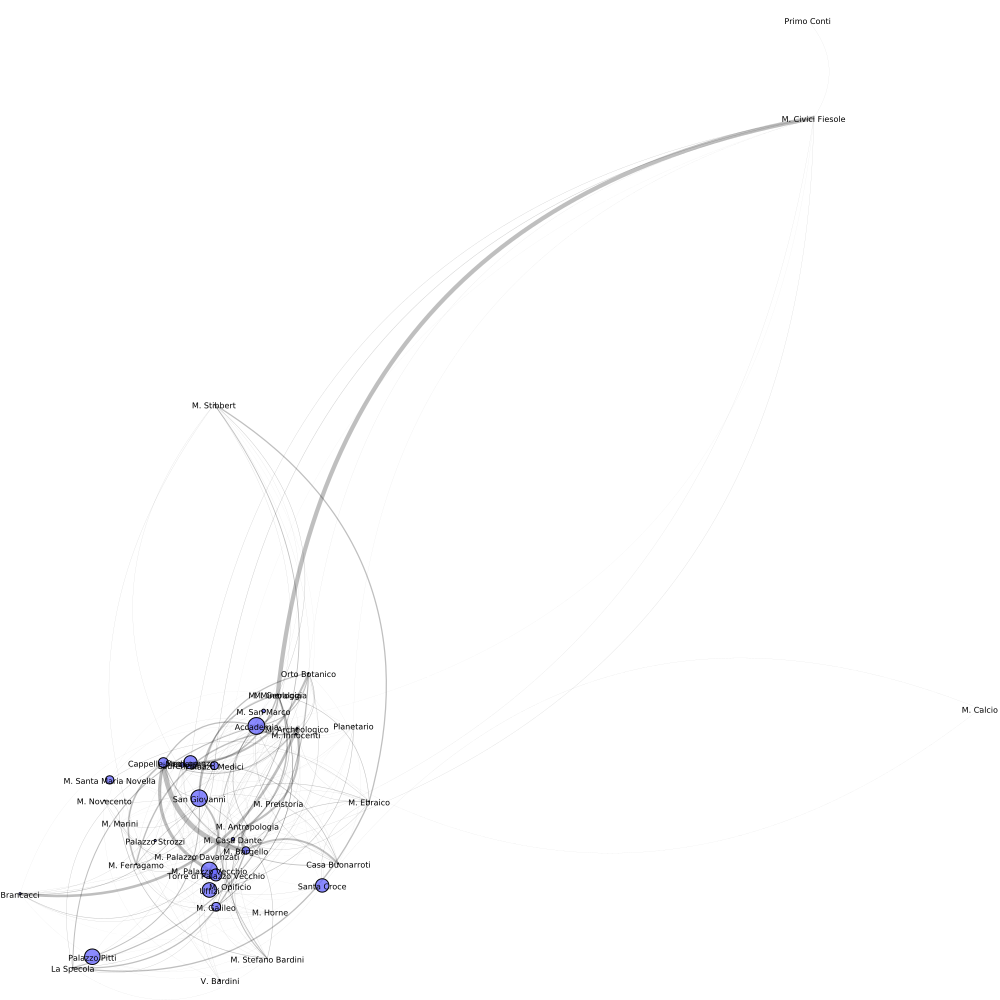

In [37]:
visual_style = {}
visual_style["edge_width"] = [.001*i for i in g2.es["weight"]] # Scale weights. .001*i chosen by hand. Try also .05*np.sqrt(i)
visual_style['edge_arrow_size'] = [.00025*i for i in g2.es["weight"]] # .00025*i chosen by hand. Try also .01*np.sqrt(i)
visual_style['vertex_label_size'] = 8
visual_style['vertex_color'] = "rgba(100, 100, 255, .75)"
visual_style['edge_color'] = "rgba(0, 0, 0, .25)"
visual_style['edge_curved'] = True
ig.plot(g2.as_undirected(), 'graph.svg', bbox = (1000,1000), **visual_style)

In [38]:
# print(g2.get_adjacency()) # This was another check; before it was very nearly upper triangular. Now it looks much better. Copy into a text editor and resize to see the whole matrix.

In [39]:
transition_matrix = pd.DataFrame(g2.get_adjacency(attribute='weight').data, columns=g2.vs['name'], index=g2.vs['name'])

In [40]:
transition_matrix

,Accademia,Brancacci,Cappelle Medicee,Casa Buonarroti,La Specola,Laurenziana,M. Antropologia,M. Archeologico,M. Bargello,M. Calcio,...,Planetario,San Giovanni,San Lorenzo,Santa Croce,Torre di Palazzo Vecchio,Uffizi,V. Bardini,M. Horne,M. Preistoria,Primo Conti
Accademia,2,77,1277,49,30,301,51,826,1022,2,...,34,4958,1885,1277,94,3151,26,0,0,0
Brancacci,80,0,66,6,74,7,0,6,99,0,...,2,172,51,289,8,114,42,2,0,0
Cappelle Medicee,1587,98,1,21,11,1411,16,61,479,0,...,4,1538,4261,525,26,625,10,0,0,0
Casa Buonarroti,43,15,21,0,0,4,10,8,152,0,...,2,80,26,450,3,46,2,4,0,0
La Specola,35,13,8,0,0,0,0,0,7,0,...,0,23,12,34,3,23,26,0,0,0
Laurenziana,319,48,1147,10,8,0,6,14,142,0,...,5,447,3139,215,1,166,5,1,2,0
M. Antropologia,54,4,10,8,4,0,0,9,141,0,...,0,75,31,57,2,44,2,2,0,0
M. Archeologico,226,8,47,7,7,6,15,2,46,0,...,12,178,63,86,11,90,2,0,0,0
M. Bargello,747,154,313,153,19,54,137,31,0,0,...,1,1000,201,2011,77,1155,20,8,0,0
M. Calcio,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0


In [41]:
# transition_matrix.reindex()
order = transition_matrix.sum(1).sort_values(ascending=False).to_frame().index
transition_matrix[order].reindex(order)

,San Giovanni,Uffizi,Accademia,M. Palazzo Vecchio,San Lorenzo,Cappelle Medicee,Santa Croce,Palazzo Pitti,M. Santa Maria Novella,M. Bargello,...,M. Horne,M. Stefano Bardini,M. Civici Fiesole,M. Mineralogia,M. Marini,Planetario,M. Stibbert,M. Preistoria,M. Calcio,Primo Conti
San Giovanni,0,3975,6066,4189,2370,1392,2304,2064,1407,1704,...,3,13,33,2,15,8,5,2,0,0
Uffizi,2923,0,3103,4545,482,356,3042,4655,563,1481,...,18,9,19,4,5,0,9,0,0,0
Accademia,4958,3151,2,1569,1885,1277,1277,1722,889,1022,...,0,8,57,15,5,34,20,0,2,0
M. Palazzo Vecchio,838,1841,458,0,135,95,873,905,244,336,...,4,4,0,0,0,0,0,0,0,0
San Lorenzo,1282,457,1235,545,1,4519,521,452,1533,257,...,1,4,8,2,9,3,9,0,0,0
Cappelle Medicee,1538,625,1587,529,4261,1,525,596,1628,479,...,0,3,10,0,1,4,6,0,0,0
Santa Croce,822,1323,1028,1831,364,208,0,1821,695,1251,...,68,41,27,2,2,6,2,4,4,0
Palazzo Pitti,837,1479,1099,1560,305,152,1249,0,591,321,...,6,33,25,0,7,1,5,0,0,0
M. Santa Maria Novella,2291,598,840,1014,916,1651,549,840,0,254,...,3,6,20,0,46,0,18,0,0,0
M. Bargello,1000,1155,747,1275,201,313,2011,811,355,0,...,8,6,8,0,2,1,3,0,0,0


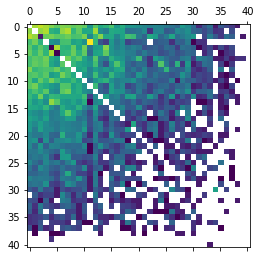

In [42]:
plt.matshow(np.log(transition_matrix[order].reindex(order)))

In [74]:
[order[0:1],order[0:]]

[Index([u'San Giovanni'], dtype='object'),
 Index([u'San Giovanni', u'Uffizi', u'Accademia', u'M. Palazzo Vecchio',
        u'San Lorenzo', u'Cappelle Medicee', u'Santa Croce', u'Palazzo Pitti',
        u'M. Santa Maria Novella', u'M. Bargello', u'Palazzo Medici',
        u'Torre di Palazzo Vecchio', u'M. Galileo', u'M. San Marco',
        u'Laurenziana', u'M. Casa Dante', u'Brancacci', u'Palazzo Strozzi',
        u'M. Archeologico ', u'M. Innocenti', u'Casa Buonarroti',
        u'M. Palazzo Davanzati', u'M. Opificio', u'M. Ebraico', u'V. Bardini',
        u'M. Novecento', u'Orto Botanico', u'La Specola', u'M. Antropologia',
        u'M. Ferragamo', u'M. Geologia', u'M. Horne', u'M. Stefano Bardini',
        u'M. Civici Fiesole', u'M. Mineralogia', u'M. Marini', u'Planetario',
        u'M. Stibbert', u'M. Preistoria', u'M. Calcio', u'Primo Conti'],
       dtype='object')]

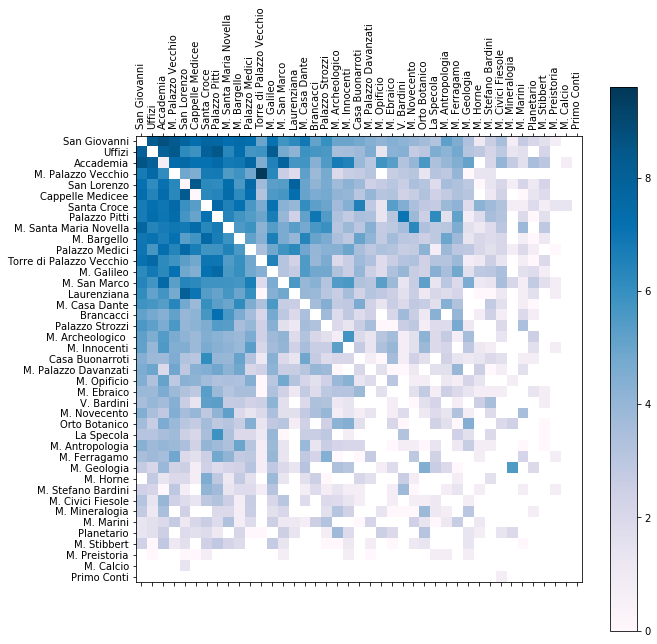

In [81]:
fig = plt.figure(figsize=(10,10))#,dpi=300)
ax = fig.add_subplot(111)
cmap=plt.cm.PuBu
# cax = ax.matshow(transition_matrix[order].reindex(order),cmap=cmap)
cax = ax.matshow(np.log(transition_matrix[order].reindex(order)),cmap=cmap)
fig.colorbar(cax)

ax.set_xticklabels(['']+order.tolist(),rotation=90)
ax.set_yticklabels(['']+order.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()